<a href="https://colab.research.google.com/github/Banafshehkh/Natural-Language-Processing/blob/main/NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author: Banafsheh Khazali
# Date: March 01, 2023

# **Semantic Text Similarity on Medical Symptoms** 


In [1]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os
import csv

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

## **Scraping the data**

To scrape the data, We can use Python libraries such as BeautifulSoup and requests. 



In [3]:
# Define the URL of the symptom checker page
url = 'https://www.mayoclinic.org/symptom-checker/select-symptom/itt-20009075'

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the response using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the section of the page that contains adult symptoms
adult_symptoms_section = soup.find('div', {'class': 'adult'})
# Check that the adult symptoms section was found
if adult_symptoms_section:
    # Find all links within the adult symptoms section
    adult_symptom_links = adult_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    adult_symptom_urls = [link['href'] for link in adult_symptom_links]

    


# Find the section of the page that contains child symptoms
child_symptoms_section = soup.find('div', {'class': 'child'})

# Check that the child symptoms section was found
if child_symptoms_section:
    # Find all links within the child symptoms section
    child_symptom_links = child_symptoms_section.find_all('a', href=True)

    # Extract the URLs from the links
    child_symptom_urls = [link['href'] for link in child_symptom_links]



# Print the URLs for the adult symptoms
full_adult_url = []
for i in adult_symptom_urls:
  full_adult_url.append("https://www.mayoclinic.org/"+i)

print('\nAdult Symptom URLs:', full_adult_url)

# Print the URLs for the child symptoms
full_child_urls = []
for i in child_symptom_urls:
  full_child_urls.append("https://www.mayoclinic.org/"+i)

print('\nChild Symptom URLs:', full_child_urls)



Adult Symptom URLs: ['https://www.mayoclinic.org//symptom-checker/abdominal-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/blood-in-stool-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/chest-pain-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/constipation-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/cough-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/diarrhea-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/difficulty-swallowing-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/dizziness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclinic.org//symptom-checker/eye-discomfort-and-redness-in-adults-adult/related-factors/itt-20009075', 'https://www.mayoclini

In [4]:
!mkdir corpus

**extract adult symptoms**

In [5]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_adult_url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    adult_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if adult_symptoms_section is not None:
        filename = f'adult_page{i+1}.txt'
        with open(f"/content/corpus/{filename}", 'w') as f:
            f.write(adult_symptoms_section.text)
    else:
        print(f"No 'adult' section found on page {i+1}")

No 'adult' section found on page 25


**extract children symptoms**

In [6]:
# Loop over the URLs and extract the relevant information
for i, url in enumerate(full_child_urls):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    child_symptoms_section = soup.find('div', {'id': 'main-content'})
    
    if child_symptoms_section is not None:
        filename = f'child_page{i+1}.txt'
        with open(f"/content/corpus/{filename}", 'w') as f:
            f.write(child_symptoms_section.text)
    else:
        print(f"No 'child' section found on page {i+1}")

No 'child' section found on page 2
No 'child' section found on page 3
No 'child' section found on page 7
No 'child' section found on page 16


## **Preprocessing the data**

To preprocess the data, We may need to clean and tokenize the text, remove stop words, and perform stemming or lemmatization.

In [9]:
!mkdir pre_corpus

**Preprocess adult/child files**

In [10]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    return lemmatized_tokens

# Define the directory where the text files are located
corpus_dir_in = '/content/corpus'
corpus_dir_out = '/content/pre_corpus'

# Create the output directory if it doesn't exist
if not os.path.exists(corpus_dir_out):
    os.makedirs(corpus_dir_out)


# Loop over the input files
for filename in os.listdir(corpus_dir_in):
    if filename.endswith('.txt'):
        # Read the input file
        with open(os.path.join(corpus_dir_in, filename), 'r') as f:
            text = f.read()
        
        # Preprocess the text
        tokens = word_tokenize(text.lower())
        filtered_tokens = [token for token in tokens if token not in stop_words]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        preprocessed_text = ' '.join(lemmatized_tokens)
        
        # Write the preprocessed text to a new file
        output_filename = os.path.join(corpus_dir_out, filename)
        with open(output_filename, 'w') as f:
            f.write(preprocessed_text)
            
        print(f'Processed file: {filename}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Processed file: adult_page22.txt
Processed file: adult_page6.txt
Processed file: child_page17.txt
Processed file: child_page4.txt
Processed file: adult_page19.txt
Processed file: adult_page11.txt
Processed file: adult_page5.txt
Processed file: child_page9.txt
Processed file: adult_page9.txt
Processed file: child_page5.txt
Processed file: adult_page27.txt
Processed file: child_page11.txt
Processed file: child_page6.txt
Processed file: adult_page15.txt
Processed file: child_page12.txt
Processed file: adult_page10.txt
Processed file: child_page8.txt
Processed file: adult_page17.txt
Processed file: adult_page1.txt
Processed file: adult_page24.txt
Processed file: adult_page20.txt
Processed file: adult_page8.txt
Processed file: adult_page3.txt
Processed file: adult_page26.txt
Processed file: child_page15.txt
Processed file: adult_page2.txt
Processed file: adult_page14.txt
Processed file: adult_page12.txt
Processed file: adult_page23.txt
Processed file: adult_page21.txt
Processed file: adult_

## **Calculating the similarity**

Calculate the similarity between the two document-term matrices using a similarity metric such as cosine similarity or Jaccard similarity.

In [11]:
# Define directory path containing text files
dir_path = '/content/pre_corpus'

# Get all text files in directory
file_names = [f for f in os.listdir(dir_path) if f.endswith('.txt')]

# Read contents of each text file and store in a list
corpus = []
for file_name in file_names:
    with open(os.path.join(dir_path, file_name), 'r') as f:
        text = f.read()
        corpus.append(text)

# Calculate TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Compute cosine similarity between all documents
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print similarity matrix.                                                                                                                                                                                                                                                                                     
print(similarity_matrix)

[[1.         0.79748944 0.67649975 ... 0.6631597  0.64647224 0.76129345]
 [0.79748944 1.         0.7468514  ... 0.72136286 0.69851629 0.87122181]
 [0.67649975 0.7468514  1.         ... 0.63580655 0.63506427 0.71799372]
 ...
 [0.6631597  0.72136286 0.63580655 ... 1.         0.60804798 0.69976572]
 [0.64647224 0.69851629 0.63506427 ... 0.60804798 1.         0.66549192]
 [0.76129345 0.87122181 0.71799372 ... 0.69976572 0.66549192 1.        ]]


##  Visualize the similarity results using a heatmap or a dendrogram

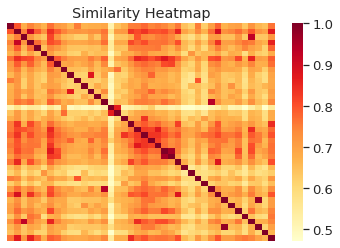

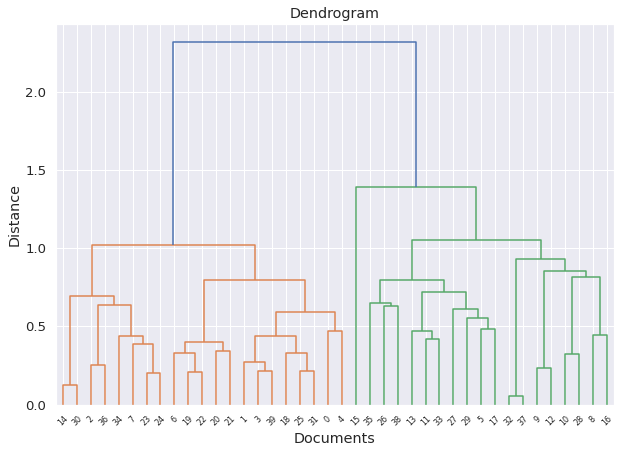

In [12]:
# Create heatmap
sns.set(font_scale=1.2)
sns.heatmap(similarity_matrix, cmap='YlOrRd', xticklabels=False, yticklabels=False)
plt.title('Similarity Heatmap')
plt.show()

# Create dendrogram
plt.figure(figsize=(10, 7))
dendrogram = hierarchy.dendrogram(hierarchy.linkage(similarity_matrix, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Documents')
plt.ylabel('Distance')
plt.show()